# Sky Patches: Tiling the Celestial Sphere

Here we will divide the sky into equal-sized "patches" for future searches.
For example: choose one patch, then find all matching difference images we wish to shift-and-stack.

This example uses the LSST spherical geometry package, which is pip installabale:
pip install lsst-sphgeom

In [1]:
# pip install lsst-sphgeom
import lsst.sphgeom as sphgeom

In [2]:
import numpy as np
import pandas as pd
import progressbar

In [3]:
# We will set up a dictionary with some values we will need for a given "instrument" here.
chipDict = {}

# Dark Energy Camera; Cerro Tololo Inter-American Observatory (CTIO), Chile
chipDict['DECam'] = {'chipsize_arcmin':[9,18]} # 0.263"/pixel, (2048,4096) pix/chip = (8.98,17.95')/chip
chipDict['DECam']['matches_per_sec'] = 20000 # estimate (based on tests against LSST DP 0.2 on RSP)
chipDict['DECam']['chips_per_mo'] = 62*1900 # estimate; 1900/mo MAX 12/20/2023 COC (mean 708) -- from COC/HARVEST
chipDict['DECam']['dec_range'] = [-90,90-30.1732] # celestial sphere zenith (90°) minus CTIO latitude (30.1732 S)

# Legacy Survey of Space and Time; Vera C. Rubin Observatory, Cerro Pachón, Chile
chipDict['LSST'] = {'chipsize_arcmin':[14,14]} # 0.2"/pixel, (4096,4096) pix/chip = (13.65',13.65')/chip
chipDict['LSST']['matches_per_sec'] = 20000 # benchmarked (RSP and local are comparable)
chipDict['LSST']['chips_per_mo'] = 189*1000*30 # 189 chips/image * 1000 images/night * 30 nights/month = about 6M chips/month
chipDict['LSST']['dec_range'] = [-90,90-30.2407] # celestial sphere zenith (90°) minus Cerro Pachón latitude (30.2407 S)
# It might be worth mentioning that the telescope cannot track below 20° elevation, and the minimum elevation is 15°.
# chipDict['LMI'] = [13,13] # 0.120"/pixel, (6144,6150) pix/chip = (12.288',12.3')/chip # just use LSST

# Made-up, very large chips for testing; note that small-angle approximations would break down in practice
chipDict['TEST'] = {'chipsize_arcmin':[3*60,3*60]} # 3 degree squares; 12/19/2023 COC
chipDict['TEST']['matches_per_sec'] = 20000 # based on what we've seen for DECam and LSST
chipDict['TEST']['chips_per_mo'] = 6000
chipDict['TEST']['dec_range'] = [-90,90]

In [4]:
def generate_patches(arcminutes, overlap_percentage, verbose=True, decRange=[-90,90], export=False):
    ''' Given a "rectangle" in (RA, Dec) touple (probably based on some chip size), 
        produce a list of bounded regions on the sky,
        with user-supplied edge overlap percentage (overlap_percentage). 
        The list is to be iterated over when matching against actual observations,
        i.e., for later shift-and-stack.
        v0: 12/11/2023 COC
        Note: this all assumes small angle approximation is OK. 1/9/2024 COC
        TODO: something to limit Dec range (min or max).
            E.g., at LSST (30.241° S) they cannot see anything above 59.759° N.
    '''
    import numpy as np
    
    def checkDec(n):
        if n > 90:
            n -= 180
        elif n < -90:
            n += 180
        return(n)
    
    def checkRA(n):
        if n > 360:
            n -= 360
        if n < 0:
            n += 360
        return(n)
    
    # Convert arcminutes to degrees (work base unit)
    arcdegrees = np.array(arcminutes) / 60.0
    
    # Calculate overlap in degrees
    overlap = arcdegrees * (overlap_percentage / 100.0)
    
    # Number of patches needed in RA, Dec space
    # TODO: consider these aren't decimal; so should be ceil for bounds 1/9/2024 COC
    num_patches_ra = int(360 / (arcdegrees[0] - overlap[0]))
    num_patches_dec = int(180 / (arcdegrees[1] - overlap[1]))
    if verbose: print(f'Number of patches in (RA, Dec): ({num_patches_ra},{num_patches_dec}).') # Recall (RA, Dec) ranges are (0-360,0-180), so square inputs result in (n*2, n) ranges.
    
    # Generate patches
    patches = []
    centers = [] # 1/15/2024 COC
    skippedBecauseOfDec = 0
    for ra_index in range(num_patches_ra):
        # Calculate corner RA coordinates; moved out of dec loop 1/11/2024 COC
        ra_start = checkRA( ra_index * (arcdegrees[0] - overlap[0]) )
        center_ra = checkRA (ra_start + arcdegrees[0]/2 ) # 1/15/2024 COC
        ra_end = checkRA( ra_start + arcdegrees[0] )
        #
        for dec_index in range(num_patches_dec):
            # Calculate corner Dec coordinates
            dec_start = checkDec( dec_index * (arcdegrees[1] - overlap[1]) - 90 )
            center_dec = checkDec (dec_start + arcdegrees[1]/2) # 1/15/2024 COC
            dec_end = checkDec( dec_start + arcdegrees[1] )
            #
            # Make sure Dec is in allowed range; KLUDGE 1/9/2024 COC
            OK = True
            for d in [dec_start, dec_end]:
                if d < decRange[0] or d > decRange[1]:
                    OK = False
                    break
            if OK == False:
                skippedBecauseOfDec += 1
#                 print(f'Something is outside of valid Dec range: dec_start={dec_start}, dec_end={dec_end}')
                continue
            #
            # Append patch coordinates to the list
            patches.append(((ra_start, dec_start), (ra_end, dec_end)))
            centers.append( (center_ra,center_dec) ) # 1/15/2024 COC

    #
    npatches = len(patches)
    info = {'npatches':npatches, 'arcminutes':arcminutes, 'overlap':overlap_percentage}
    if verbose: print(f'There were {npatches} produced, skipping {skippedBecauseOfDec} because Dec was outside {decRange}. Info: {info}.')
    #
    # produce CSV if desired
    if export == True:
        outfile = f'patches_{arcminutes[0]}x{arcminutes[1]}arcmin_{overlap_percentage}pctOverlap'
        if decRange != None:
            outfile += f'_Dec{decRange[0]}to{decRange[1]}'
        outfile += '.csv'
        with open(outfile,'w') as f:
            print(f'ra0,dec0,ra1,dec1',file=f)
            for quad in patches:
                print(f'{quad[0][0]},{quad[0][1]},{quad[1][0]},{quad[1][1]}',file=f)
            print(f'Wrote {len(patches)} patch rows to {outfile}.')
    #
    return patches, centers, info


In [5]:
# test very confined Dec case
patches_result, patches_centers, info = generate_patches(arcminutes=(15, 15), overlap_percentage=0, decRange=[-90,-89.75], export=False)
print(f"For a 15' X 15' (0.25° X 0.25°) patch, we expect 1,440 around RA (with an allowed Dec range of a single field).")
patches_result, patches_centers, info = generate_patches(arcminutes=(15, 15), overlap_percentage=0, decRange=[-90,-89.5], export=False)
print(f"Twice the height in Dec should produce twice the number of patches (2880).")

Number of patches in (RA, Dec): (1440,720).
There were 1440 produced, skipping 1035360 because Dec was outside [-90, -89.75]. Info: {'npatches': 1440, 'arcminutes': (15, 15), 'overlap': 0}.
For a 15' X 15' (0.25° X 0.25°) patch, we expect 1,440 around RA (with an allowed Dec range of a single field).
Number of patches in (RA, Dec): (1440,720).
There were 2880 produced, skipping 1033920 because Dec was outside [-90, -89.5]. Info: {'npatches': 2880, 'arcminutes': (15, 15), 'overlap': 0}.
Twice the height in Dec should produce twice the number of patches (2880).


In [6]:
# testing limited Dec case
# recall 1° = 60' = 3600"
patches_result, patches_centers, info = generate_patches(arcminutes=(480, 240), overlap_percentage=10, decRange=[-90,61], export=False)

Number of patches in (RA, Dec): (50,50).
There were 2050 produced, skipping 450 because Dec was outside [-90, 61]. Info: {'npatches': 2050, 'arcminutes': (480, 240), 'overlap': 10}.


In [7]:
# testing full Dec case
patches_result, patches_centers, info = generate_patches((480, 240), 10, decRange=[-90,90], export=False)

Number of patches in (RA, Dec): (50,50).
There were 2500 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 2500, 'arcminutes': (480, 240), 'overlap': 10}.


In [8]:
def plot_patches(patches, limit=None, xrange=[0,360], yrange=[-90,90], title=None, subfolder='.', export=False):
    import os
    os.makedirs(subfolder, exist_ok=True)
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    fig, ax = plt.subplots()
    colors = ['blue', 'orange', 'green', 'red']
    linestyles = ['solid', 'dashed']
    # c = 0
    patch_count = len(patches)
    barmax = patch_count
    if limit != None and limit < barmax:
        barmax = limit
    print(f'There are {patch_count} to plot. Processing {barmax} (limit was {limit}).', flush=True)
    #
    #
    with progressbar.ProgressBar(max_value=barmax) as bar:
        for i, patch in enumerate(patches):
            if limit != None and i > limit: 
                print(f'Breaking at limit {limit} passed to function.')
                break
            # if c >= 10000:
            #     print(f'Row {i!s:6} of {patch_count}')
            #     c = 0
            (ra_start, dec_start), (ra_end, dec_end) = patch
            width = ra_end - ra_start
            height = dec_end - dec_start
            
            # Alternating fill color and line style
            color = colors[i % len(colors)]
            linestyle = linestyles[i % len(linestyles)]
            
            # Plot rectangle
            rect = Rectangle((ra_start, dec_start), width, height, edgecolor=color, facecolor='none', linestyle=linestyle, alpha=0.5)
            ax.add_patch(rect)
            #
            # c += 1
            bar.update(i)
    # Set axis labels and limits
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
#    ax.set_xlim(0, 360)
#    ax.set_ylim(-90, 90)
    ax.set_xlim(xrange[0], xrange[1])
    ax.set_ylim(yrange[0], yrange[1])
    
    plt.grid(True)
    
    outfile_base = f'{subfolder}/patches'
    if title != None: 
        plt.title(title)
        outfile_base += f'_{info["arcminutes"][0]}_{info["arcminutes"][1]}_{info["overlap"]}'
    
    if export == True:
        for ext in ['png', 'pdf']:
            plt.savefig(f'{outfile_base}.{ext}')
        print(f'Wrote "{outfile_base} (prefix) plots to disk.')
    plt.show()

Number of patches in (RA, Dec): (45,45).
There were 2025 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 2025, 'arcminutes': (480, 240), 'overlap': 0}.
There are 2025 to plot. Processing 2025 (limit was None).


100% (2025 of 2025) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


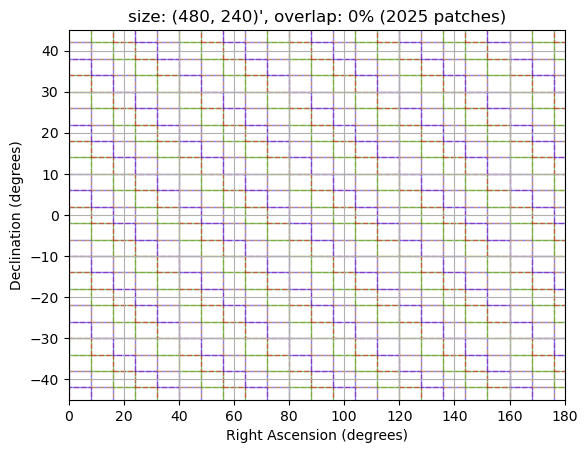

Number of patches in (RA, Dec): (50,50).
There were 2500 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 2500, 'arcminutes': (480, 240), 'overlap': 10}.
There are 2500 to plot. Processing 2500 (limit was None).


100% (2500 of 2500) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


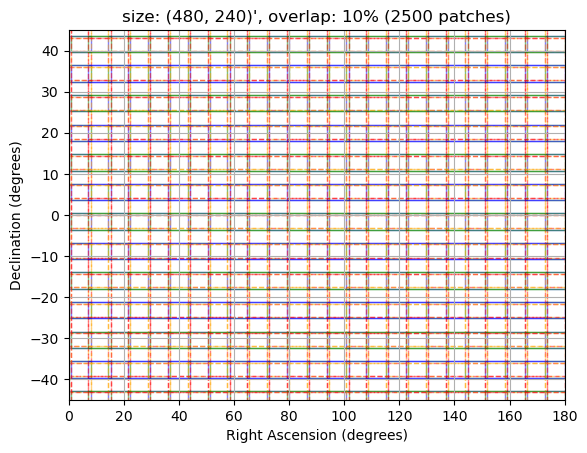

Number of patches in (RA, Dec): (56,56).
There were 3136 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 3136, 'arcminutes': (480, 240), 'overlap': 20}.
There are 3136 to plot. Processing 3136 (limit was None).


100% (3136 of 3136) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


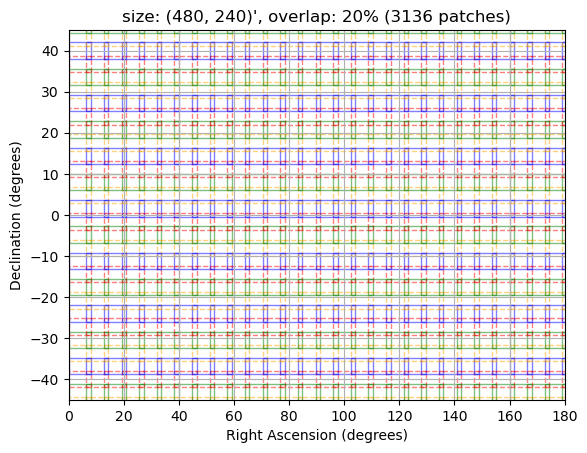

Number of patches in (RA, Dec): (64,64).
There were 4096 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 4096, 'arcminutes': (480, 240), 'overlap': 30}.
There are 4096 to plot. Processing 4096 (limit was None).


100% (4096 of 4096) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


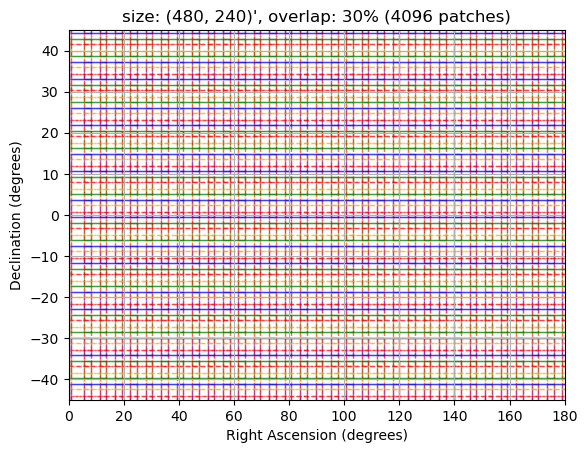

Number of patches in (RA, Dec): (75,75).
There were 5625 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 5625, 'arcminutes': (480, 240), 'overlap': 40}.
There are 5625 to plot. Processing 5625 (limit was None).


100% (5625 of 5625) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


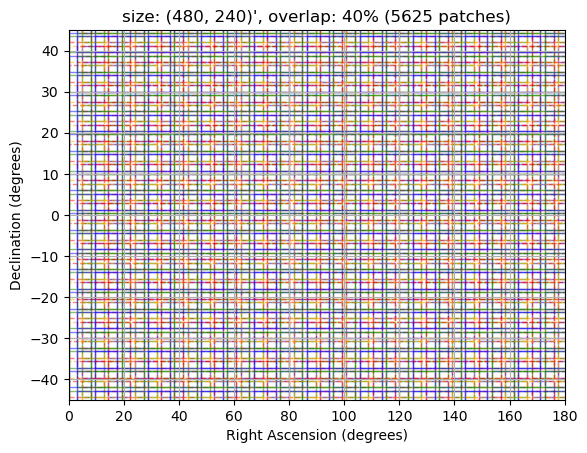

Number of patches in (RA, Dec): (90,90).
There were 8100 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 8100, 'arcminutes': (480, 240), 'overlap': 50}.
There are 8100 to plot. Processing 8100 (limit was None).


100% (8100 of 8100) |####################| Elapsed Time: 0:00:04 Time:  0:00:04


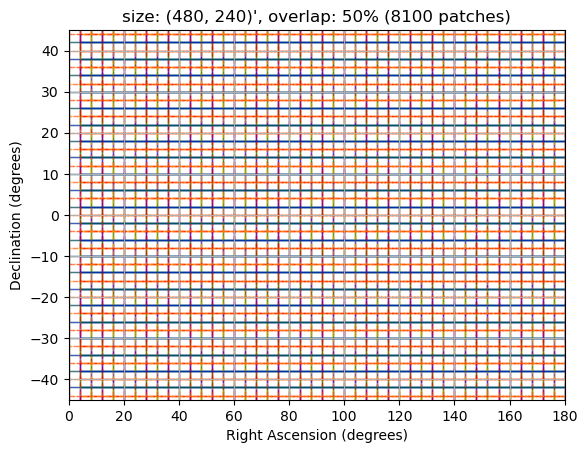

In [9]:
#plot_patches(patches_result, xrange=[0,180], yrange=[-45,45], title=f"size: {info['arcminutes']}', overlap: {info['overlap']}%")# , limit=1000)
for i in [0, 10, 20, 30, 40, 50]:
    arcminutes_input = (480, 240)  # Dimensions of each patch in arcminutes; produces 10000 with 10% overlap
#   overlap_percentage_input = i  # Percentage of overlap
    patches_result, patches_centers, info = generate_patches(arcminutes_input, 
                                            i, 
                                            #decRange=[-90,61], 
                                            export=False
                                           )
    plot_patches(patches_result, xrange=[0,180], yrange=[-45,45], title=f"size: {info['arcminutes']}', overlap: {info['overlap']}% ({info['npatches']} patches)", subfolder='generic')# , limit=1000)


In [10]:
# This takes a *very* long time, so turning it off by default 1/11/2024 COC
doit = False
if doit == True:
    overlaps = [0,10,25,50]
    for i in overlaps: # [0, 10, 20, 30, 40, 50]: # changed to iterate of overlap first 12/11/2023 COC
        for chip in chipDict:
            print(f'Working on {chip} with {i} overlap next...')
            arcminutes_input = chipDict[chip]['chipsize_arcmin'] # Dimensions of each patch in arcminutes
            overlap_percentage_input = i  # Percentage of overlap
            patches_result, patches_centers, info = generate_patches(arcminutes_input, i, decRange=chipDict[chip]['dec_range'])
            plot_patches(patches_result, 
                         xrange=[0,180], 
                         yrange=[-45,45], 
                         title=f"{chip}: size {info['arcminutes']}', overlap: {info['overlap']}% ({info['npatches']} patches)",
                         subfolder = f'{chip}',
                        )# , limit=1000)


In [11]:
def secondsToPrettierTime(t):
    '''
    handled <= 60 s case 1/9/2024 COC
    added rounding 1/9/2024 COC
    '''
    u = 's'
    if t <= 60:
        return(round(t,3), u)
    if t > 60:
        t /= 60
        u = 'min'
    if t > 60:
        t /= 60
        u = 'hr'
    if t > 24:
        t /= 24
        u = 'day'
    if t > 365.25 and u == 'day':
        t /= 365.25
        u = 'yr'
        return(round(t,3), u)
    if t > 30 and u == 'day':
        t /= 30
        u = 'mo'
        return(round(t,3), u)
    return(round(t,3), u)
#     raise ValueError(f'This should not be possible! Have unit "{u}" and t={t}.')

In [12]:
def benchmarkPatchesOnly(chipDict, overlaps=[0,10,20,30,40,50], exportPatches=False, exportCSVs=False):
    '''
    12/11/2023 COC -- only test number of patches generated (do not plot)
    '''
    import pandas as pd
    import os
#   all_results = {'chip':[],'npatches':[],'matching_time':[]}
    all_results = {'chip':[], 'overlap':[], 'npatches':[], 'matching_time_s':[], 'match_rate':[], 'chips_per_mo':[], 'side1arcmin':[], 'side2arcmin':[]}
    for chip in chipDict:
        print(f'Working on {chip}...')
        os.makedirs(chip, exist_ok=True)
        chip_results = {'chip':[], 'overlap':[], 'npatches':[], 'matching_time_s':[], 'match_rate':[], 'chips_per_mo':[], 'side1arcmin':[], 'side2arcmin':[]}
        for overlap in overlaps:
            arcminutes_input = chipDict[chip]['chipsize_arcmin'] # Dimensions of each patch in arcminutes
            match_rate = chipDict[chip]['matches_per_sec'] # get these first in case of typo or something
            chips_per_mo = chipDict[chip]['chips_per_mo']
#           overlap_percentage_input = overlap  # Percentage of overlap
            patches_result, patches_centers, info = generate_patches(arcminutes_input, overlap, export=exportPatches, decRange=chipDict[chip]['dec_range'])
            # info = {'npatches':npatches, 'arcminutes':arcminutes, 'overlap':overlap_percentage}
            npatches = info['npatches']
            match_time = (npatches * chips_per_mo) / match_rate
            for d in [all_results, chip_results]:
                d['chip'].append(chip)
                d['overlap'].append(overlap)
                d['npatches'].append(npatches)
                d['matching_time_s'].append(match_time)
                d['match_rate'].append(match_rate)
                d['chips_per_mo'].append(chips_per_mo)
                d['side1arcmin'].append(arcminutes_input[0])
                d['side2arcmin'].append(arcminutes_input[1])
            prettyTime, u = secondsToPrettierTime(match_time)
            print(f'{chip}: overlap {i}, npatches={npatches}, time = {prettyTime} {u}')
        if exportCSVs == True:
            this_csv = f'{chip}/pathes.csv'
            patchdf = pd.DataFrame.from_dict(chip_results)
            patchdf.to_csv(this_csv,index=False)
            print(f'Wrote {this_csv} to disk.')
    allcsv = f'all_patches_results.csv'
    alldf = pd.DataFrame.from_dict(all_results)
    if exportCSVs == True:
        alldf.to_csv(allcsv, index=False)
        print(f'Wrote all results (all chips) to {allcsv}.')
    return(alldf)


In [13]:
alldf = benchmarkPatchesOnly(chipDict=chipDict)

Working on DECam...
Number of patches in (RA, Dec): (2400,600).
There were 1197600 produced, skipping 242400 because Dec was outside [-90, 59.8268]. Info: {'npatches': 1197600, 'arcminutes': [9, 18], 'overlap': 0}.
DECam: overlap 50, npatches=1197600, time = 2.721 mo
Number of patches in (RA, Dec): (2666,666).
There were 1476964 produced, skipping 298592 because Dec was outside [-90, 59.8268]. Info: {'npatches': 1476964, 'arcminutes': [9, 18], 'overlap': 10}.
DECam: overlap 50, npatches=1476964, time = 3.356 mo
Number of patches in (RA, Dec): (3000,750).
There were 1872000 produced, skipping 378000 because Dec was outside [-90, 59.8268]. Info: {'npatches': 1872000, 'arcminutes': [9, 18], 'overlap': 20}.
DECam: overlap 50, npatches=1872000, time = 4.254 mo
Number of patches in (RA, Dec): (3428,857).
There were 2444164 produced, skipping 493632 because Dec was outside [-90, 59.8268]. Info: {'npatches': 2444164, 'arcminutes': [9, 18], 'overlap': 30}.
DECam: overlap 50, npatches=2444164, t

In [14]:
# add a column that shows the matching time in serial compute years
alldf['matching_time_yr'] = alldf['matching_time_s']/(365.25*24*60*60)

In [15]:
alldf

,chip,overlap,npatches,matching_time_s,match_rate,chips_per_mo,side1arcmin,side2arcmin,matching_time_yr
0,DECam,0,1197600,7.053864e+06,20000,117800,9,18,0.223523
1,DECam,10,1476964,8.699318e+06,20000,117800,9,18,0.275665
2,DECam,20,1872000,1.102608e+07,20000,117800,9,18,0.349395
3,DECam,30,2444164,1.439613e+07,20000,117800,9,18,0.456186
4,DECam,40,3324000,1.957836e+07,20000,117800,9,18,0.620401
5,DECam,50,4785600,2.818718e+07,20000,117800,9,18,0.893198
6,LSST,0,988422,2.802176e+08,20000,5670000,14,14,8.879561
7,LSST,10,1222082,3.464602e+08,20000,5670000,14,14,10.978663
8,LSST,20,1546256,4.383636e+08,20000,5670000,14,14,13.890903
9,LSST,30,2018864,5.723479e+08,20000,5670000,14,14,18.136612
